In [9]:
# import data from the SR datasets.
# visualise the pareto frontier (accuracy vs cost) for a selected config

In [53]:
import pandas as pd
import os
import numpy as np
from pathlib import Path
import sys

repo_root = Path.cwd().parent
sys.path.insert(0, str(repo_root))
from will_replication.my_utils.utils import plot_pareto_frontier

In [73]:
BASELINE_DATASETS_LIST = [
                        "opencompass/AIME2025", #test
                        "gneubig/aime-1983-2024", #train
                        "openai/gsm8k", #test
                        "DigitalLearningGmbH/MATH-lighteval" #test
                        ]

In [74]:
MODEL_POOL = [
    "Qwen-Qwen2.5-Math-1.5B-Instruct",
    "Qwen-Qwen2.5-Math-7B-Instruct",
    # "Qwen-Qwen2.5-Math-72B-Instruct",
              ]

In [75]:
# GENERATION_CONFIG
K=1
TEMP=0.0

In [76]:
PLOTTING_DICT = dict()
for BASELINE_DATASET_NAME in BASELINE_DATASETS_LIST:
    BASELINE_BENCHMARK_ALIAS = "_".join(BASELINE_DATASET_NAME.split("/"))

    BENCHMARK_DATA_POINTS = []
    for MODEL_NAME in MODEL_POOL:
        if "aime-1983" in BASELINE_BENCHMARK_ALIAS: #only has train set
            BASELINE_PATH = f"../will_replication/DATA/SR_DATA/{BASELINE_BENCHMARK_ALIAS}/train-{MODEL_NAME}_maxlen_3000_k_{K}_temp_{TEMP}.parquet"
        else:
            BASELINE_PATH = f"../will_replication/DATA/SR_DATA/{BASELINE_BENCHMARK_ALIAS}/test-{MODEL_NAME}_maxlen_3000_k_{K}_temp_{TEMP}.parquet"

        BASELINE_BENCHMARK_DF = pd.read_parquet(BASELINE_PATH)

        benchmark_sr_score = BASELINE_BENCHMARK_DF["success_rate"].mean()

        if "majority_vote_is_correct" in BASELINE_BENCHMARK_DF.columns:
            benchmark_majority_vote_score = BASELINE_BENCHMARK_DF["majority_vote_is_correct"].mean()
        else:
            benchmark_majority_vote_score = np.nan

        benchmark_cost = BASELINE_BENCHMARK_DF["total_cost_usd"].sum()
        BENCHMARK_DATA_POINTS.append({"name": MODEL_NAME, "passk_score": benchmark_sr_score, "majority_vote_score":benchmark_majority_vote_score, "cost": benchmark_cost})
        
    PLOTTING_DICT[BASELINE_BENCHMARK_ALIAS] = BENCHMARK_DATA_POINTS

In [77]:
BASELINE_BENCHMARK_DF

,idx,problem,formatted_prompt,ground_truth,generated_solutions,total_input_tokens,total_output_tokens,total_cost_usd,input_cost_usd_once,success_rate,model_name,task,split,problem_id,total_output_cost_usd,majority_vote_extracted_answer,majority_vote_is_correct
0,0,How many vertical asymptotes does the graph of...,<|im_start|>system\nPlease reason step by step...,2,[{'input_cost_usd_once': 9.791999999999999e-06...,68,425,0.000132,0.000010,1.0,Qwen/Qwen2.5-Math-7B-Instruct,DigitalLearningGmbH_MATH-lighteval,test,SG93IG1hbnkgdmVydGljYWwgYXN5bXB0b3RlcyBkb2VzIH...,0.000122,2,1.0
1,1,What is the positive difference between $120\%...,<|im_start|>system\nPlease reason step by step...,10,[{'input_cost_usd_once': 1.0511999999999999e-0...,73,288,0.000093,0.000011,1.0,Qwen/Qwen2.5-Math-7B-Instruct,DigitalLearningGmbH_MATH-lighteval,test,V2hhdCBpcyB0aGUgcG9zaXRpdmUgZGlmZmVyZW5jZSBiZX...,0.000083,10,1.0
2,2,Find $x$ such that $\lceil x \rceil + x = \dfr...,<|im_start|>system\nPlease reason step by step...,\dfrac{9}{7},[{'input_cost_usd_once': 1.1231999999999999e-0...,78,726,0.000220,0.000011,1.0,Qwen/Qwen2.5-Math-7B-Instruct,DigitalLearningGmbH_MATH-lighteval,test,RmluZCAkeCQgc3VjaCB0aGF0ICRcbGNlaWwgeCBccmNlaW...,0.000208,\frac{9}{7},1.0
3,3,Evaluate $i^5+i^{-25}+i^{45}$.,<|im_start|>system\nPlease reason step by step...,i,"[{'input_cost_usd_once': 8.64e-06, 'input_toke...",60,349,0.000109,0.000009,1.0,Qwen/Qwen2.5-Math-7B-Instruct,DigitalLearningGmbH_MATH-lighteval,test,RXZhbHVhdGUgJGleNStpXnstMjV9K2leezQ1fSQu,0.000100,i,1.0
4,4,"If $2^8=4^x$, what is the value of $x$?",<|im_start|>system\nPlease reason step by step...,4,"[{'input_cost_usd_once': 8.928e-06, 'input_tok...",62,196,0.000065,0.000009,1.0,Qwen/Qwen2.5-Math-7B-Instruct,DigitalLearningGmbH_MATH-lighteval,test,SWYgJDJeOD00XngkLCB3aGF0IGlzIHRoZSB2YWx1ZSBvZi...,0.000056,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,If $\sin x + \cos x = \frac{1}{5}$ and $0 < x ...,<|im_start|>system\nPlease reason step by step...,-\frac{4}{3},[{'input_cost_usd_once': 1.0511999999999999e-0...,73,881,0.000263,0.000011,1.0,Qwen/Qwen2.5-Math-7B-Instruct,DigitalLearningGmbH_MATH-lighteval,test,SWYgJFxzaW4geCArIFxjb3MgeCA9IFxmcmFjezF9ezV9JC...,0.000253,-\frac{4}{3},1.0
4996,4996,The matrix for projecting onto a certain plane...,<|im_start|>system\nPlease reason step by step...,\begin{pmatrix} 1 \\ 2 \\ -3 \end{pmatrix},[{'input_cost_usd_once': 3.6287999999999995e-0...,252,1253,0.000396,0.000036,1.0,Qwen/Qwen2.5-Math-7B-Instruct,DigitalLearningGmbH_MATH-lighteval,test,VGhlIG1hdHJpeCBmb3IgcHJvamVjdGluZyBvbnRvIGEgY2...,0.000360,\begin{pmatrix} 1 \\ 2 \\ -3 \end{pmatrix},1.0
4997,4997,"Let $\mathbf{a},$ $\mathbf{b},$ and $\mathbf{c...",<|im_start|>system\nPlease reason step by step...,-\frac{155}{2},"[{'input_cost_usd_once': 2.6496e-05, 'input_to...",184,1080,0.000336,0.000026,1.0,Qwen/Qwen2.5-Math-7B-Instruct,DigitalLearningGmbH_MATH-lighteval,test,TGV0ICRcbWF0aGJme2F9LCQgJFxtYXRoYmZ7Yn0sJCBhbm...,0.000310,-\frac{155}{2},1.0
4998,4998,Find the smallest positive integer solution to...,<|im_start|>system\nPlease reason step by step...,159,"[{'input_cost_usd_once': 1.4544e-05, 'input_to...",101,1193,0.000357,0.000015,0.0,Qwen/Qwen2.5-Math-7B-Instruct,DigitalLearningGmbH_MATH-lighteval,test,RmluZCB0aGUgc21hbGxlc3QgcG9zaXRpdmUgaW50ZWdlci...,0.000342,24,0.0


In [78]:
PLOTTING_DICT

{'opencompass_AIME2025': [{'name': 'Qwen-Qwen2.5-Math-1.5B-Instruct',
   'passk_score': 0.06666666666666667,
   'majority_vote_score': 0.06666666666666667,
   'cost': 0.0016274999999999998},
  {'name': 'Qwen-Qwen2.5-Math-7B-Instruct',
   'passk_score': 0.13333333333333333,
   'majority_vote_score': 0.13333333333333333,
   'cost': 0.005432609000000001}],
 'gneubig_aime-1983-2024': [{'name': 'Qwen-Qwen2.5-Math-1.5B-Instruct',
   'passk_score': 0.2765273311897106,
   'majority_vote_score': 0.2765273311897106,
   'cost': 0.10679630000000001},
  {'name': 'Qwen-Qwen2.5-Math-7B-Instruct',
   'passk_score': 0.2872454448017149,
   'majority_vote_score': 0.2872454448017149,
   'cost': 0.34985345999999995}],
 'openai_gsm8k': [{'name': 'Qwen-Qwen2.5-Math-1.5B-Instruct',
   'passk_score': 0.8362395754359363,
   'majority_vote_score': 0.8362395754359363,
   'cost': 0.05617280000000001},
  {'name': 'Qwen-Qwen2.5-Math-7B-Instruct',
   'passk_score': 0.9393479909021987,
   'majority_vote_score': 0.9393

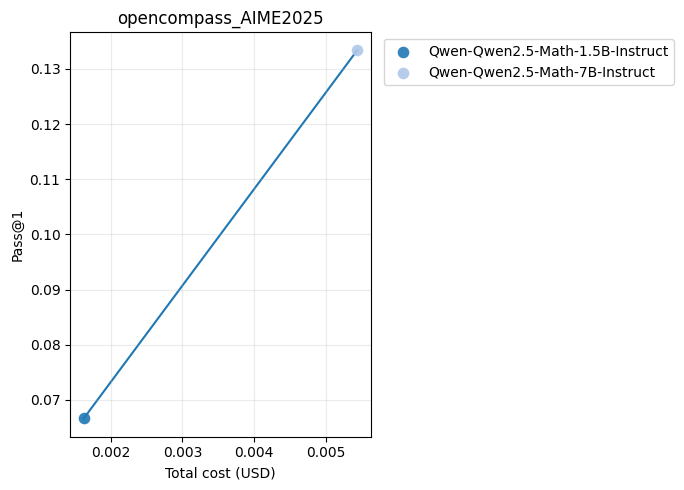

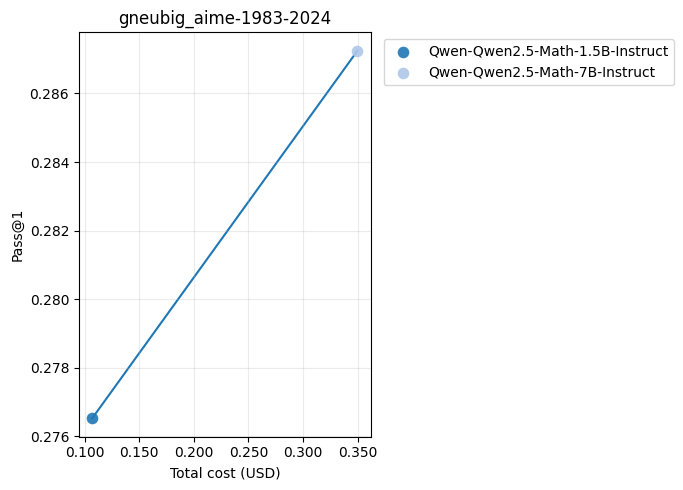

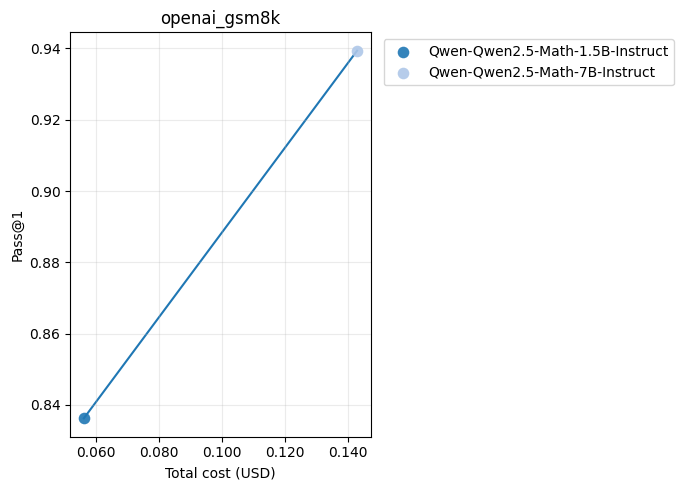

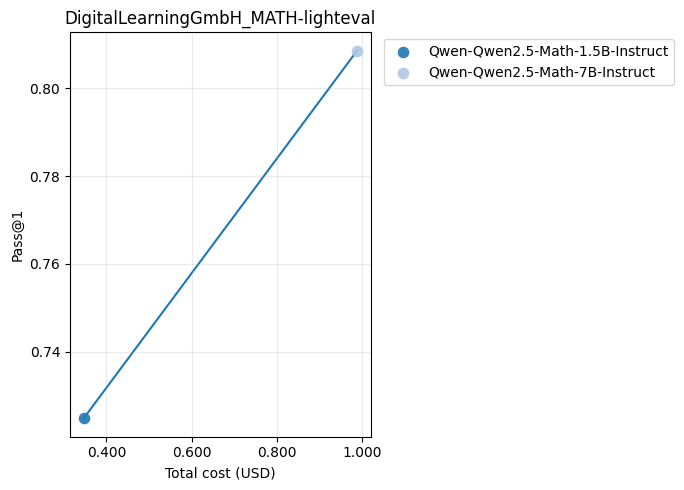

In [79]:
for benchmark, data_points in PLOTTING_DICT.items():
    plot_pareto_frontier(data_points, benchmark, score_col="passk_score", x_label="Total cost (USD)", y_label=f"Pass@{K}")